**Important: This notebook will only work with fastai-0.7.x. Do not try to run any fastai-1.x code from this path in the repository because it will load fastai-0.7.x**

# Intro to Random Forests

## About this course

### Teaching approach

This course is being taught by Jeremy Howard, and was developed by Jeremy along with Rachel Thomas. Rachel has been dealing with a life-threatening illness so will not be teaching as originally planned this year.

Jeremy has worked in a number of different areas - feel free to ask about anything that he might be able to help you with at any time, even if not directly related to the current topic:

- Management consultant (McKinsey; AT Kearney)
- Self-funded startup entrepreneur (Fastmail: first consumer synchronized email; Optimal Decisions: first optimized insurance pricing)
- VC-funded startup entrepreneur: (Kaggle; Enlitic: first deep-learning medical company)

I'll be using a *top-down* teaching method, which is different from how most math courses operate.  Typically, in a *bottom-up* approach, you first learn all the separate components you will be using, and then you gradually build them up into more complex structures.  The problems with this are that students often lose motivation, don't have a sense of the "big picture", and don't know what they'll need.

If you took the fast.ai deep learning course, that is what we used.  You can hear more about my teaching philosophy [in this blog post](http://www.fast.ai/2016/10/08/teaching-philosophy/) or [in this talk](https://vimeo.com/214233053).

Harvard Professor David Perkins has a book, [Making Learning Whole](https://www.amazon.com/Making-Learning-Whole-Principles-Transform/dp/0470633719) in which he uses baseball as an analogy.  We don't require kids to memorize all the rules of baseball and understand all the technical details before we let them play the game.  Rather, they start playing with a just general sense of it, and then gradually learn more rules/details as time goes on.

All that to say, don't worry if you don't understand everything at first!  You're not supposed to.  We will start using some "black boxes" such as random forests that haven't yet been explained in detail, and then we'll dig into the lower level details later.

To start, focus on what things DO, not what they ARE.

### Your practice

People learn by:
1. **doing** (coding and building)
2. **explaining** what they've learned (by writing or helping others)

Therefore, we suggest that you practice these skills on Kaggle by:
1. Entering competitions (*doing*)
2. Creating Kaggle kernels (*explaining*)

It's OK if you don't get good competition ranks or any kernel votes at first - that's totally normal! Just try to keep improving every day, and you'll see the results over time.

To get better at technical writing, study the top ranked Kaggle kernels from past competitions, and read posts from well-regarded technical bloggers. Some good role models include:

- [Peter Norvig](http://nbviewer.jupyter.org/url/norvig.com/ipython/ProbabilityParadox.ipynb) (more [here](http://norvig.com/ipython/))
- [Stephen Merity](https://smerity.com/articles/2017/deepcoder_and_ai_hype.html)
- [Julia Evans](https://codewords.recurse.com/issues/five/why-do-neural-networks-think-a-panda-is-a-vulture) (more [here](https://jvns.ca/blog/2014/08/12/what-happens-if-you-write-a-tcp-stack-in-python/))
- [Julia Ferraioli](http://blog.juliaferraioli.com/2016/02/exploring-world-using-vision-twilio.html)
- [Edwin Chen](http://blog.echen.me/2014/10/07/moving-beyond-ctr-better-recommendations-through-human-evaluation/)
- [Slav Ivanov](https://blog.slavv.com/picking-an-optimizer-for-style-transfer-86e7b8cba84b) (fast.ai student)
- [Brad Kenstler](https://hackernoon.com/non-artistic-style-transfer-or-how-to-draw-kanye-using-captain-picards-face-c4a50256b814) (fast.ai and USF MSAN student)

### Books

The more familiarity you have with numeric programming in Python, the better. If you're looking to improve in this area, we strongly suggest Wes McKinney's [Python for Data Analysis, 2nd ed](https://www.amazon.com/Python-Data-Analysis-Wrangling-IPython/dp/1491957662/ref=asap_bc?ie=UTF8).

For machine learning with Python, we recommend:

- [Introduction to Machine Learning with Python](https://www.amazon.com/Introduction-Machine-Learning-Andreas-Mueller/dp/1449369413): From one of the scikit-learn authors, which is the main library we'll be using
- [Python Machine Learning: Machine Learning and Deep Learning with Python, scikit-learn, and TensorFlow, 2nd Edition](https://www.amazon.com/Python-Machine-Learning-scikit-learn-TensorFlow/dp/1787125939/ref=dp_ob_title_bk): New version of a very successful book. A lot of the new material however covers deep learning in Tensorflow, which isn't relevant to this course
- [Hands-On Machine Learning with Scikit-Learn and TensorFlow](https://www.amazon.com/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1491962291/ref=pd_lpo_sbs_14_t_0?_encoding=UTF8&psc=1&refRID=MBV2QMFH3EZ6B3YBY40K)


### Syllabus in brief

Depending on time and class interests, we'll cover something like (not necessarily in this order):

- Train vs test
  - Effective validation set construction
- Trees and ensembles
  - Creating random forests
  - Interpreting random forests
- What is ML?  Why do we use it?
  - What makes a good ML project?
  - Structured vs unstructured data
  - Examples of failures/mistakes
- Feature engineering
  - Domain specific - dates, URLs, text
  - Embeddings / latent factors
- Regularized models trained with SGD
  - GLMs, Elasticnet, etc (NB: see what James covered)
- Basic neural nets
  - PyTorch
  - Broadcasting, Matrix Multiplication
  - Training loop, backpropagation
- KNN
- CV / bootstrap (Diabetes data set?)
- Ethical considerations

Skip:

- Dimensionality reduction
- Interactions
- Monitoring training
- Collaborative filtering
- Momentum and LR annealing


## Imports

In [58]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
from fastai.imports import *
from fastai.structured import *

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

In [60]:
PATH = "data/bulldozers/"

In [61]:
!ls {PATH}

Train.csv


# Introduction to *Blue Book for Bulldozers*

## About...

### ...our teaching

At fast.ai we have a distinctive [teaching philosophy](http://www.fast.ai/2016/10/08/teaching-philosophy/) of ["the whole game"](https://www.amazon.com/Making-Learning-Whole-Principles-Transform/dp/0470633719/ref=sr_1_1?ie=UTF8&qid=1505094653).  This is different from how most traditional math & technical courses are taught, where you have to learn all the individual elements before you can combine them (Harvard professor David Perkins call this *elementitis*), but it is similar to how topics like *driving* and *baseball* are taught.  That is, you can start driving without [knowing how an internal combustion engine works](https://medium.com/towards-data-science/thoughts-after-taking-the-deeplearning-ai-courses-8568f132153), and children begin playing baseball before they learn all the formal rules.

### ...our approach to machine learning

Most machine learning courses will throw at you dozens of different algorithms, with a brief technical description of the math behind them, and maybe a toy example. You're left confused by the enormous range of techniques shown and have little practical understanding of how to apply them.

The good news is that modern machine learning can be distilled down to a couple of key techniques that are of very wide applicability. Recent studies have shown that the vast majority of datasets can be best modeled with just two methods:

- *Ensembles of decision trees* (i.e. Random Forests and Gradient Boosting Machines), mainly for structured data (such as you might find in a database table at most companies)
- *Multi-layered neural networks learnt with SGD* (i.e. shallow and/or deep learning), mainly for unstructured data (such as audio, vision, and natural language)

In this course we'll be doing a deep dive into random forests, and simple models learnt with SGD. You'll be learning about gradient boosting and deep learning in part 2.

### ...this dataset

We will be looking at the Blue Book for Bulldozers Kaggle Competition: "The goal of the contest is to predict the sale price of a particular piece of heavy equiment at auction based on it's usage, equipment type, and configuration.  The data is sourced from auction result postings and includes information on usage and equipment configurations."

This is a very common type of dataset and prediciton problem, and similar to what you may see in your project or workplace.

### ...Kaggle Competitions

Kaggle is an awesome resource for aspiring data scientists or anyone looking to improve their machine learning skills.  There is nothing like being able to get hands-on practice and receiving real-time feedback to help you improve your skills.

Kaggle provides:

1. Interesting data sets
2. Feedback on how you're doing
3. A leader board to see what's good, what's possible, and what's state-of-art.
4. Blog posts by winning contestants share useful tips and techniques.

## The data

### Look at the data

Kaggle provides info about some of the fields of our dataset; on the [Kaggle Data info](https://www.kaggle.com/c/bluebook-for-bulldozers/data) page they say the following:

For this competition, you are predicting the sale price of bulldozers sold at auctions. The data for this competition is split into three parts:

- **Train.csv** is the training set, which contains data through the end of 2011.
- **Valid.csv** is the validation set, which contains data from January 1, 2012 - April 30, 2012. You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
- **Test.csv** is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

The key fields are in train.csv are:

- SalesID: the unique identifier of the sale
- MachineID: the unique identifier of a machine.  A machine can be sold multiple times
- saleprice: what the machine sold for at auction (only provided in train.csv)
- saledate: the date of the sale

*Question*

What stands out to you from the above description?  What needs to be true of our training and validation sets?

In [62]:
df_raw = pd.read_csv(f'{PATH}Train.csv', low_memory=False, 
                     parse_dates=["saledate"])

In any sort of data science work, it's **important to look at your data**, to make sure you understand the format, how it's stored, what type of values it holds, etc. Even if you've read descriptions about your data, the actual data may not be what you expect.

In [63]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [64]:
display_all(df_raw.tail().T)

,401120,401121,401122,401123,401124
SalesID,6333336,6333337,6333338,6333341,6333342
SalePrice,10500,11000,11500,9000,7750
MachineID,1840702,1830472,1887659,1903570,1926965
ModelID,21439,21439,21439,21435,21435
datasource,149,149,149,149,149
auctioneerID,1,1,1,2,2
YearMade,2005,2005,2005,2005,2005
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-10-25 00:00:00,2011-10-25 00:00:00


In [65]:
display_all(df_raw.describe(include='all').T)

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
SalesID,401125,NaN,NaN,NaN,NaT,NaT,1.91971e+06,909021,1.13925e+06,1.41837e+06,1.63942e+06,2.24271e+06,6.33334e+06
SalePrice,401125,NaN,NaN,NaN,NaT,NaT,31099.7,23036.9,4750,14500,24000,40000,142000
MachineID,401125,NaN,NaN,NaN,NaT,NaT,1.2179e+06,440992,0,1.0887e+06,1.27949e+06,1.46807e+06,2.48633e+06
ModelID,401125,NaN,NaN,NaN,NaT,NaT,6889.7,6221.78,28,3259,4604,8724,37198
datasource,401125,NaN,NaN,NaN,NaT,NaT,134.666,8.96224,121,132,132,136,172
auctioneerID,380989,NaN,NaN,NaN,NaT,NaT,6.55604,16.9768,0,1,2,4,99
YearMade,401125,NaN,NaN,NaN,NaT,NaT,1899.16,291.797,1000,1985,1995,2000,2013
MachineHoursCurrentMeter,142765,NaN,NaN,NaN,NaT,NaT,3457.96,27590.3,0,0,0,3025,2.4833e+06
UsageBand,69639,3,Medium,33985,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
saledate,401125,3919,2009-02-16 00:00:00,1932,1989-01-17,2011-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN


It's important to note what metric is being used for a project. Generally, selecting the metric(s) is an important part of the project setup. However, in this case Kaggle tells us what metric to use: RMSLE (root mean squared log error) between the actual and predicted auction prices. Therefore we take the log of the prices, so that RMSE will give us what we need.

In [66]:
df_raw.SalePrice = np.log(df_raw.SalePrice)

### Initial processing

In [67]:
try:
    m = RandomForestRegressor(n_estimators=10, n_jobs=-1)
    # The following code is supposed to fail due to string values in the input data
    m.fit(df_raw.drop('SalePrice', axis=1), df_raw.SalePrice)
except:
    print("something went wrong.")

something went wrong.


This dataset contains a mix of **continuous** and **categorical** variables.

The following method extracts particular date fields from a complete datetime for the purpose of constructing categoricals.  You should always consider this feature extraction step when working with date-time. Without expanding your date-time into these additional fields, you can't capture any trend/cyclical behavior as a function of time at any of these granularities.

In [68]:
add_datepart(df_raw, 'saledate')
df_raw.saleYear.head()

0    2006
1    2004
2    2004
3    2011
4    2009
Name: saleYear, dtype: int64

The categorical variables are currently stored as strings, which is inefficient, and doesn't provide the numeric coding required for a random forest. Therefore we call `train_cats` to convert strings to pandas categories.

In [69]:
train_cats(df_raw)

We can specify the order to use for categorical variables if we wish:

In [70]:
df_raw.UsageBand.cat.categories

Index(['High', 'Low', 'Medium'], dtype='object')

In [71]:
df_raw.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)

Normally, pandas will continue displaying the text categories, while treating them as numerical data internally. Optionally, we can replace the text categories with numbers, which will make this variable non-categorical, like so:.

In [72]:
df_raw.UsageBand = df_raw.UsageBand.cat.codes

We're still not quite done - for instance we have lots of missing values, which we can't pass directly to a random forest.

In [73]:
display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

Backhoe_Mounting            0.803872
Blade_Extension             0.937129
Blade_Type                  0.800977
Blade_Width                 0.937129
Coupler                     0.466620
Coupler_System              0.891660
Differential_Type           0.826959
Drive_System                0.739829
Enclosure                   0.000810
Enclosure_Type              0.937129
Engine_Horsepower           0.937129
Forks                       0.521154
Grouser_Tracks              0.891899
Grouser_Type                0.752813
Hydraulics                  0.200823
Hydraulics_Flow             0.891899
MachineHoursCurrentMeter    0.644089
MachineID                   0.000000
ModelID                     0.000000
Pad_Type                    0.802720
Pattern_Changer             0.752651
ProductGroup                0.000000
ProductGroupDesc            0.000000
ProductSize                 0.525460
Pushblock                   0.937129
Ride_Control                0.629527
Ripper                      0.740388
S

But let's save this file for now, since it's already in format can we be stored and accessed efficiently.

In [74]:
os.makedirs('tmp', exist_ok=True)
df_raw.to_feather('tmp/bulldozers-raw')

# Random Forests

### Pre-processing

In the future we can simply read it from this fast format.

In [153]:
import feather
df_raw = feather.read_dataframe('tmp/bulldozers-raw')

We'll replace categories with their numeric codes, handle missing continuous values, and split the dependent variable into a separate variable.

In [154]:
df, y, nas = proc_df(df_raw, 'SalePrice')

We now have something we can pass to a random forest!

In [155]:
m = RandomForestRegressor(n_estimators=10, n_jobs=-1)
m.fit(df, y)
m.score(df,y)

0.8794200777440735

In statistics, the coefficient of determination, denoted R2 or r2 and pronounced "R squared", is the proportion of the variance in the dependent variable that is predictable from the independent variable(s). https://en.wikipedia.org/wiki/Coefficient_of_determination

Wow, an r^2 of 0.98 - that's great, right? Well, perhaps not...

Possibly **the most important idea** in machine learning is that of having separate training & validation data sets. As motivation, suppose you don't divide up your data, but instead use all of it.  And suppose you have lots of parameters:

<img src="images/overfitting2.png" alt="" style="width: 70%"/>
<center>
[Underfitting and Overfitting](https://datascience.stackexchange.com/questions/361/when-is-a-model-underfitted)
</center>

The error for the pictured data points is lowest for the model on the far right (the blue curve passes through the red points almost perfectly), yet it's not the best choice.  Why is that?  If you were to gather some new data points, they most likely would not be on that curve in the graph on the right, but would be closer to the curve in the middle graph.

This illustrates how using all our data can lead to **overfitting**. A validation set helps diagnose this problem.

In [156]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 12000  # same as Kaggle's test set size
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((389125, 66), (389125,), (12000, 66))

## Base model

Let's try our model again, this time with separate training and validation sets.

In [157]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def get_scores(m, config):
    res = {
        'config':[config],
        'rmse_train': [rmse(m.predict(X_train), y_train)], 
        'rmse_dev': [rmse(m.predict(X_valid), y_valid)],
        'r^2_train': [m.score(X_train, y_train)], 
        'r^2_dev': [m.score(X_valid, y_valid)],
        'oob': [None],
        'n_trees':[m.n_estimators],
        'train_size': [len(y_train)],
        'dev_size': [len(y_valid)],
    }
    if hasattr(m, 'oob_score_'): res['oob'][0] = m.oob_score_
    return pd.DataFrame(res)

In [158]:
m = RandomForestRegressor(n_estimators=10, n_jobs=-1)
%time m.fit(X_train, y_train)

CPU times: user 6.7 s, sys: 218 ms, total: 6.92 s
Wall time: 1.85 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [159]:
results = get_scores(m, 'baseline-slow')
results

,config,rmse_train,rmse_dev,r^2_train,r^2_dev,oob,n_trees,train_size,dev_size
0,baseline (slow),0.240873,0.275556,0.878741,0.864397,None,10,389125,12000


An r^2 in the high-80's isn't bad at all (and the RMSLE puts us around rank 100 of 470 on the Kaggle leaderboard), but we can see from the validation set score that we're over-fitting badly. To understand this issue, let's simplify things down to a single small tree.

## Speeding things up

In [160]:
nas

{'auctioneerID': 2.0, 'MachineHoursCurrentMeter': 0.0}

In [161]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice', subset=30000, na_dict=nas)
X_train, _ = split_vals(df_trn, 20000)
y_train, _ = split_vals(y_trn, 20000)

In [162]:
nas

{'auctioneerID': 2.0, 'MachineHoursCurrentMeter': 0.0}

In [163]:
m = RandomForestRegressor(n_estimators=10, n_jobs=-1)
%time m.fit(X_train, y_train)

CPU times: user 2.25 s, sys: 22.4 ms, total: 2.28 s
Wall time: 374 ms


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [164]:
tmp = get_scores(m, 'speedup')
tmp

,config,rmse_train,rmse_dev,r^2_train,r^2_dev,oob,n_trees,train_size,dev_size
0,speedup,0.112813,0.355151,0.972244,0.774745,None,10,20000,12000


In [165]:
results = pd.concat([results, tmp])
results

,config,rmse_train,rmse_dev,r^2_train,r^2_dev,oob,n_trees,train_size,dev_size
0,baseline (slow),0.240873,0.275556,0.878741,0.864397,None,10,389125,12000
0,speedup,0.112813,0.355151,0.972244,0.774745,None,10,20000,12000


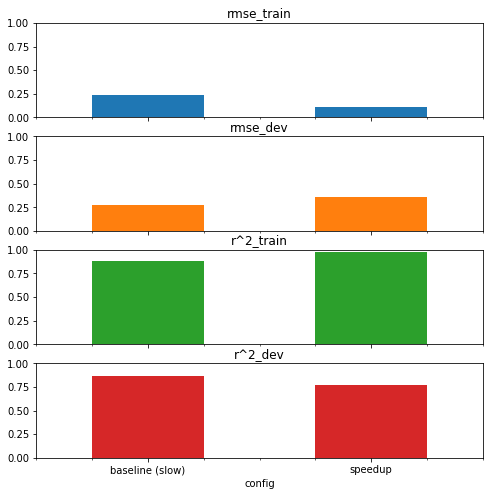

In [171]:
cols = results.columns[:5]
results[cols].plot.bar(
    x='config', 
    subplots=True, 
    rot=0, 
    ylim=(0,1), 
    # title=['']*4,
    legend=False,
    figsize=(8,8)
);

## Single tree

In [172]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=3,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [173]:
tmp = get_scores(m, 'single tree')
tmp

,config,rmse_train,rmse_dev,r^2_train,r^2_dev,oob,n_trees,train_size,dev_size
0,single tree,0.523167,0.582178,0.403082,0.394716,None,1,20000,12000


In [174]:
results = pd.concat([results, tmp])
results

,config,rmse_train,rmse_dev,r^2_train,r^2_dev,oob,n_trees,train_size,dev_size
0,baseline (slow),0.240873,0.275556,0.878741,0.864397,None,10,389125,12000
0,speedup,0.112813,0.355151,0.972244,0.774745,None,10,20000,12000
0,single tree,0.523167,0.582178,0.403082,0.394716,None,1,20000,12000


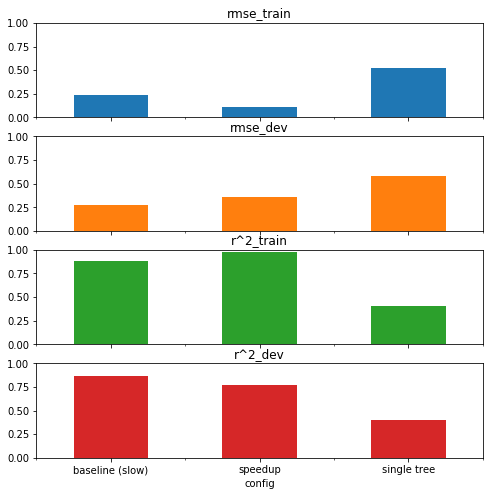

In [176]:
cols = results.columns[:5]
results[cols].plot.bar(
    x='config', 
    subplots=True, 
    rot=0, 
    ylim=(0,1), 
    # title=['']*4,
    legend=False,
    figsize=(8,8)
);

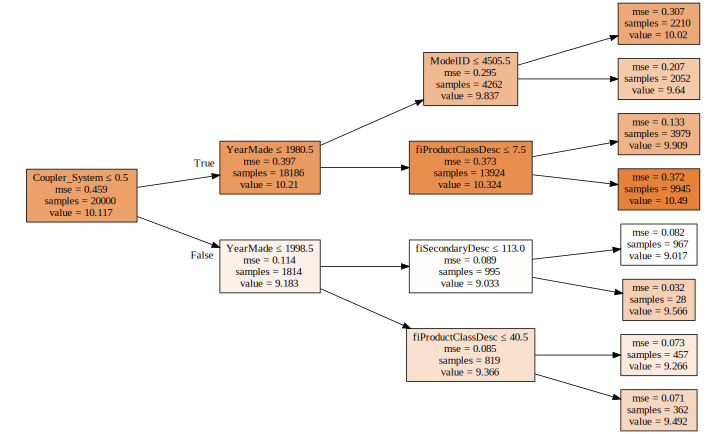

In [177]:
draw_tree(m.estimators_[0], df_trn, precision=3)

Let's see what happens if we create a bigger tree.

In [178]:
m = RandomForestRegressor(n_estimators=1, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [179]:
tmp = get_scores(m, 'single deep tree')
tmp

,config,rmse_train,rmse_dev,r^2_train,r^2_dev,oob,n_trees,train_size,dev_size
0,single deep tree,5.891509e-17,0.476779,1.0,0.594041,None,1,20000,12000


In [180]:
results = pd.concat([results, tmp])
results

,config,rmse_train,rmse_dev,r^2_train,r^2_dev,oob,n_trees,train_size,dev_size
0,baseline (slow),2.408734e-01,0.275556,0.878741,0.864397,None,10,389125,12000
0,speedup,1.128131e-01,0.355151,0.972244,0.774745,None,10,20000,12000
0,single tree,5.231667e-01,0.582178,0.403082,0.394716,None,1,20000,12000
0,single deep tree,5.891509e-17,0.476779,1.000000,0.594041,None,1,20000,12000


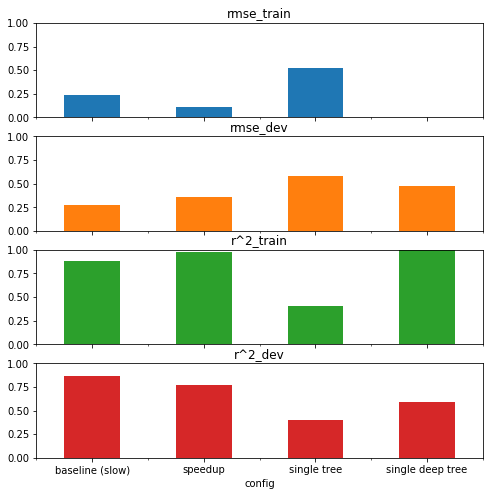

In [181]:
cols = results.columns[:5]
results[cols].plot.bar(
    x='config', 
    subplots=True, 
    rot=0, 
    ylim=(0,1), 
    # title=['']*4,
    legend=False,
    figsize=(8,8)
);

The training set result looks great! But the validation set is worse than our original model. This is why we need to use *bagging* of multiple trees to get more generalizable results.

## Bagging

### Intro to bagging

To learn about bagging in random forests, let's start with our basic model again.

In [182]:
m = RandomForestRegressor(n_estimators=10, n_jobs=-1)
m.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [183]:
tmp = get_scores(m, 'baseline-fast')
tmp

,config,rmse_train,rmse_dev,r^2_train,r^2_dev,oob,n_trees,train_size,dev_size
0,baseline (fast),0.11255,0.376143,0.972374,0.74733,None,10,20000,12000


In [184]:
results = pd.concat([results, tmp])
results

,config,rmse_train,rmse_dev,r^2_train,r^2_dev,oob,n_trees,train_size,dev_size
0,baseline (slow),2.408734e-01,0.275556,0.878741,0.864397,None,10,389125,12000
0,speedup,1.128131e-01,0.355151,0.972244,0.774745,None,10,20000,12000
0,single tree,5.231667e-01,0.582178,0.403082,0.394716,None,1,20000,12000
0,single deep tree,5.891509e-17,0.476779,1.000000,0.594041,None,1,20000,12000
0,baseline (fast),1.125500e-01,0.376143,0.972374,0.747330,None,10,20000,12000


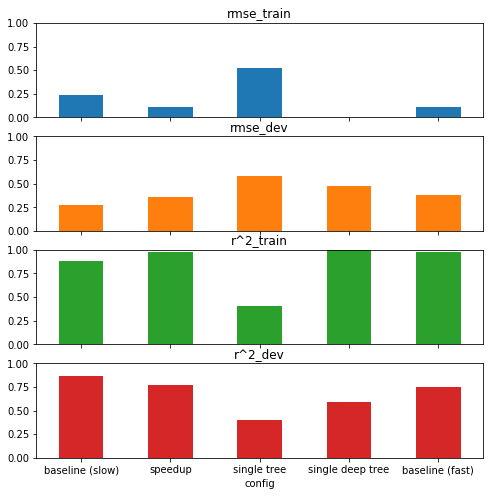

In [185]:
cols = results.columns[:5]
results[cols].plot.bar(
    x='config', 
    subplots=True, 
    rot=0, 
    ylim=(0,1), 
    # title=['']*4,
    legend=False,
    figsize=(8,8)
);

We'll grab the predictions for each individual tree, and look at one example.

In [186]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[0]

(array([8.9872 , 9.13238, 9.32367, 9.87817, 8.92266, 9.30565, 9.32367, 8.92266, 9.32812, 9.30565]),
 9.242982462052904,
 9.104979856318357)

In [187]:
preds.shape

(10, 12000)

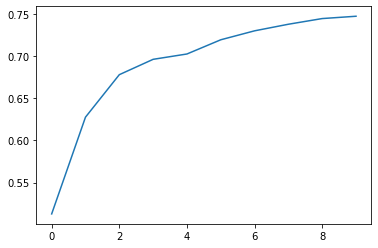

In [188]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)]);

The shape of this curve suggests that adding more trees isn't going to help us much. Let's check. (Compare this to our original model on a sample)

In [189]:
m = RandomForestRegressor(n_estimators=20, n_jobs=-1)
m.fit(X_train, y_train)
get_scores(m, "")

,config,rmse_train,rmse_dev,r^2_train,r^2_dev,oob,n_trees,train_size,dev_size
0,,0.101743,0.34911,0.977424,0.782344,None,20,20000,12000


In [190]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1)
m.fit(X_train, y_train)
get_scores(m, "")

,config,rmse_train,rmse_dev,r^2_train,r^2_dev,oob,n_trees,train_size,dev_size
0,,0.096853,0.340969,0.979542,0.792376,None,40,20000,12000


In [196]:
m = RandomForestRegressor(n_estimators=80, n_jobs=-1)
m.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [199]:
tmp = get_scores(m, "baseline-fast-80")
tmp

,config,rmse_train,rmse_dev,r^2_train,r^2_dev,oob,n_trees,train_size,dev_size
0,baseline (fast) (80),0.094081,0.341856,0.980696,0.791295,None,80,20000,12000


In [200]:
results = pd.concat([results, tmp])
results

,config,rmse_train,rmse_dev,r^2_train,r^2_dev,oob,n_trees,train_size,dev_size
0,baseline (slow),2.408734e-01,0.275556,0.878741,0.864397,None,10,389125,12000
0,speedup,1.128131e-01,0.355151,0.972244,0.774745,None,10,20000,12000
0,single tree,5.231667e-01,0.582178,0.403082,0.394716,None,1,20000,12000
0,single deep tree,5.891509e-17,0.476779,1.000000,0.594041,None,1,20000,12000
0,baseline (fast),1.125500e-01,0.376143,0.972374,0.747330,None,10,20000,12000
0,baseline (fast) (80),9.408126e-02,0.341856,0.980696,0.791295,None,80,20000,12000


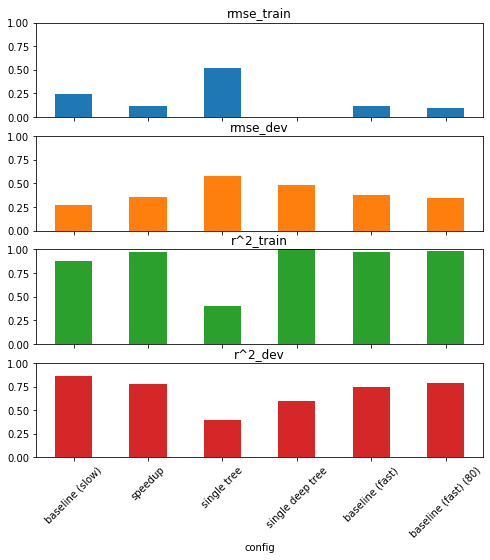

In [205]:
cols = results.columns[:5]
results[cols].plot.bar(
    x='config', 
    subplots=True, 
    rot=45,
    ylim=(0,1), 
    # title=['']*4,
    legend=False,
    figsize=(8,8),
);

### Out-of-bag (OOB) score

Is our validation set worse than our training set because we're over-fitting, or because the validation set is for a different time period, or a bit of both? With the existing information we've shown, we can't tell. However, random forests have a very clever trick called *out-of-bag (OOB) error* which can handle this (and more!)

The idea is to calculate error on the training set, but only include the trees in the calculation of a row's error where that row was *not* included in training that tree. This allows us to see whether the model is over-fitting, without needing a separate validation set.

This also has the benefit of allowing us to see whether our model generalizes, even if we only have a small amount of data so want to avoid separating some out to create a validation set.

This is as simple as adding one more parameter to our model constructor. We print the OOB error last in our `print_score` function below.

In [207]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
                      oob_score=True, random_state=None, verbose=0,
                      warm_start=False)

In [210]:
tmp = get_scores(m, "baseline-fast-40-oob")
tmp

,config,rmse_train,rmse_dev,r^2_train,r^2_dev,oob,n_trees,train_size,dev_size
0,baseline-fast-40-oob,0.096523,0.344561,0.979681,0.787978,0.855158,40,20000,12000


In [211]:
results = pd.concat([results, tmp])
results

,config,rmse_train,rmse_dev,r^2_train,r^2_dev,oob,n_trees,train_size,dev_size
0,baseline (slow),2.408734e-01,0.275556,0.878741,0.864397,None,10,389125,12000
0,speedup,1.128131e-01,0.355151,0.972244,0.774745,None,10,20000,12000
0,single tree,5.231667e-01,0.582178,0.403082,0.394716,None,1,20000,12000
0,single deep tree,5.891509e-17,0.476779,1.000000,0.594041,None,1,20000,12000
0,baseline (fast),1.125500e-01,0.376143,0.972374,0.747330,None,10,20000,12000
0,baseline (fast) (80),9.408126e-02,0.341856,0.980696,0.791295,None,80,20000,12000
0,baseline-fast-40-oob,9.652284e-02,0.344561,0.979681,0.787978,0.855158,40,20000,12000


This shows that our validation set time difference is making an impact, as is model over-fitting.

## Reducing over-fitting

### Subsampling

It turns out that one of the easiest ways to avoid over-fitting is also one of the best ways to speed up analysis: *subsampling*. Let's return to using our full dataset, so that we can demonstrate the impact of this technique.

In [214]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

The basic idea is this: rather than limit the total amount of data that our model can access, let's instead limit it to a *different* random subset per tree. That way, given enough trees, the model can still see *all* the data, but for each individual tree it'll be just as fast as if we had cut down our dataset as before.

In [215]:
set_rf_samples(20000)

In [216]:
m = RandomForestRegressor(n_estimators=10, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)

CPU times: user 7.1 s, sys: 287 ms, total: 7.38 s
Wall time: 2.64 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                      oob_score=True, random_state=None, verbose=0,
                      warm_start=False)

In [220]:
tmp = get_scores(m, "baseline-subsample-10")
tmp

,config,rmse_train,rmse_dev,r^2_train,r^2_dev,oob,n_trees,train_size,dev_size
0,baseline-subsample-10,0.240103,0.280116,0.879516,0.859873,0.866935,10,389125,12000


In [221]:
results = pd.concat([results, tmp])
results

,config,rmse_train,rmse_dev,r^2_train,r^2_dev,oob,n_trees,train_size,dev_size
0,baseline (slow),2.408734e-01,0.275556,0.878741,0.864397,None,10,389125,12000
0,speedup,1.128131e-01,0.355151,0.972244,0.774745,None,10,20000,12000
0,single tree,5.231667e-01,0.582178,0.403082,0.394716,None,1,20000,12000
0,single deep tree,5.891509e-17,0.476779,1.000000,0.594041,None,1,20000,12000
0,baseline (fast),1.125500e-01,0.376143,0.972374,0.747330,None,10,20000,12000
0,baseline (fast) (80),9.408126e-02,0.341856,0.980696,0.791295,None,80,20000,12000
0,baseline-fast-40-oob,9.652284e-02,0.344561,0.979681,0.787978,0.855158,40,20000,12000
0,baseline-subsample-10,2.401031e-01,0.280116,0.879516,0.859873,0.866935,10,389125,12000


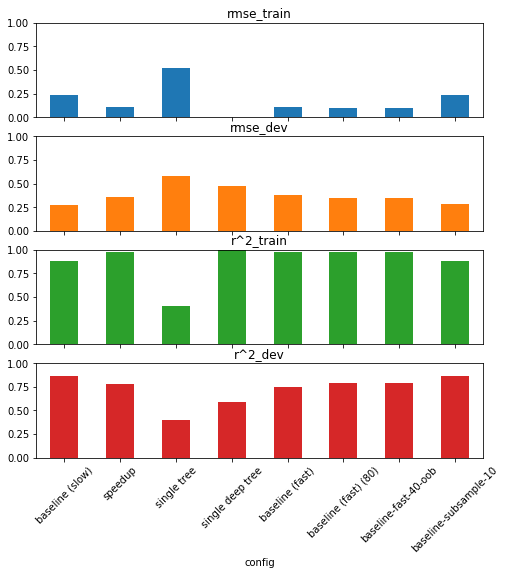

In [222]:
cols = results.columns[:5]
results[cols].plot.bar(
    x='config', 
    subplots=True, 
    rot=45,
    ylim=(0,1), 
    # title=['']*4,
    legend=False,
    figsize=(8,8),
);

Since each additional tree allows the model to see more data, this approach can make additional trees more useful.

In [223]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
                      oob_score=True, random_state=None, verbose=0,
                      warm_start=False)

In [224]:
tmp = get_scores(m, "baseline-subsample-40")
tmp

,config,rmse_train,rmse_dev,r^2_train,r^2_dev,oob,n_trees,train_size,dev_size
0,baseline-subsample-40,0.227196,0.262661,0.892121,0.876792,0.880582,40,389125,12000


In [226]:
results = pd.concat([results, tmp])
results

,config,rmse_train,rmse_dev,r^2_train,r^2_dev,oob,n_trees,train_size,dev_size
0,baseline (slow),2.408734e-01,0.275556,0.878741,0.864397,None,10,389125,12000
0,speedup,1.128131e-01,0.355151,0.972244,0.774745,None,10,20000,12000
0,single tree,5.231667e-01,0.582178,0.403082,0.394716,None,1,20000,12000
0,single deep tree,5.891509e-17,0.476779,1.000000,0.594041,None,1,20000,12000
0,baseline (fast),1.125500e-01,0.376143,0.972374,0.747330,None,10,20000,12000
0,baseline (fast) (80),9.408126e-02,0.341856,0.980696,0.791295,None,80,20000,12000
0,baseline-fast-40-oob,9.652284e-02,0.344561,0.979681,0.787978,0.855158,40,20000,12000
0,baseline-subsample-10,2.401031e-01,0.280116,0.879516,0.859873,0.866935,10,389125,12000
0,baseline-subsample-40,2.271957e-01,0.262661,0.892121,0.876792,0.880582,40,389125,12000


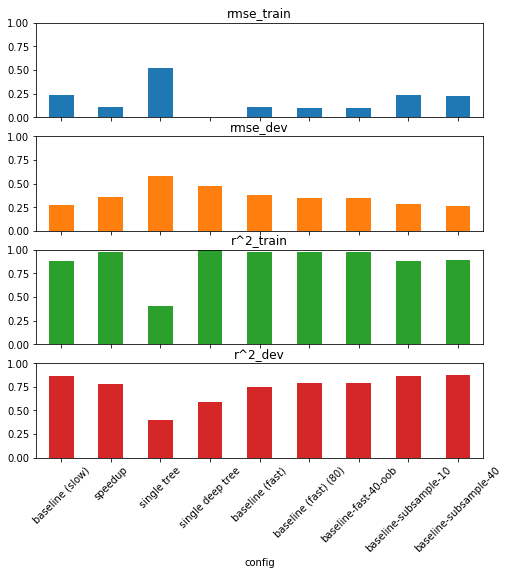

In [227]:
cols = results.columns[:5]
results[cols].plot.bar(
    x='config', 
    subplots=True, 
    rot=45,
    ylim=(0,1), 
    # title=['']*4,
    legend=False,
    figsize=(8,8),
);

### Tree building parameters

We revert to using a full bootstrap sample in order to show the impact of other over-fitting avoidance methods.

In [ ]:
reset_rf_samples()

Let's get a baseline for this full set to compare to.

In [ ]:
def dectree_max_depth(tree):
    children_left = tree.children_left
    children_right = tree.children_right

    def walk(node_id):
        if (children_left[node_id] != children_right[node_id]):
            left_max = 1 + walk(children_left[node_id])
            right_max = 1 + walk(children_right[node_id])
            return max(left_max, right_max)
        else: # leaf
            return 1

    root_node_id = 0
    return walk(root_node_id)

In [ ]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

In [ ]:
t=m.estimators_[0].tree_

In [ ]:
dectree_max_depth(t)

In [ ]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

In [ ]:
t=m.estimators_[0].tree_

In [ ]:
dectree_max_depth(t)

Another way to reduce over-fitting is to grow our trees less deeply. We do this by specifying (with `min_samples_leaf`) that we require some minimum number of rows in every leaf node. This has two benefits:

- There are less decision rules for each leaf node; simpler models should generalize better
- The predictions are made by averaging more rows in the leaf node, resulting in less volatility

In [ ]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

We can also increase the amount of variation amongst the trees by not only use a sample of rows for each tree, but to also using a sample of *columns* for each *split*. We do this by specifying `max_features`, which is the proportion of features to randomly select from at each split.

- None
- 0.5
- 'sqrt'

- 1, 3, 5, 10, 25, 100

In [ ]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

We can't compare our results directly with the Kaggle competition, since it used a different validation set (and we can no longer to submit to this competition) - but we can at least see that we're getting similar results to the winners based on the dataset we have.

The sklearn docs [show an example](http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html) of different `max_features` methods with increasing numbers of trees - as you see, using a subset of features on each split requires using more trees, but results in better models:
![sklearn max_features chart](http://scikit-learn.org/stable/_images/sphx_glr_plot_ensemble_oob_001.png)